# This new ML pipeline enables equal representation of each polarization state in each train, test, and validation dataset
### In the future, if needed, refactor into functions for efficiency

In [1]:
import sys
sys.path.append('..')

In [2]:
import torch
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import random
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns

In [3]:
from core.getdata import *
from core.dataset import *
from core.network import *
from core.trainer import *
from core.visualization import *

In [4]:
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor

In [5]:
ligands = ["TNF", "R84", "PIC", "P3K", "FLA", "CpG", "FSL", "LPS", "UST"]
polarization = ["", "ib", "ig", "i0", "i3", "i4"]
replicas, size = 2, 1288 # replicated

In [6]:
asd = DatasetPolar(ligands, polarization, replicas, size)

In [7]:
asd.labels.shape

(69552,)

In [8]:
m0 = DatasetPolar(ligands, [""], replicas, size)
ib = DatasetPolar(ligands, ["ib"], replicas, size)
ig = DatasetPolar(ligands, ["ig"], replicas, size)
i0 = DatasetPolar(ligands, ["i0"], replicas, size)
i3 = DatasetPolar(ligands, ["i3"], replicas, size)
i4 = DatasetPolar(ligands, ["i4"], replicas, size)

In [9]:
print(len(m0), len(ib), len(ig), len(i0), len(i3), len(i4))

11592 11592 11592 11592 11592 11592


In [10]:
m0_train, m0_val, m0_test = torch.utils.data.random_split(m0, [6956, 2318, 2318])
ib_train, ib_val, ib_test = torch.utils.data.random_split(ib, [6956, 2318, 2318])
ig_train, ig_val, ig_test = torch.utils.data.random_split(ig, [6956, 2318, 2318])
i0_train, i0_val, i0_test = torch.utils.data.random_split(i0, [6956, 2318, 2318])
i3_train, i3_val, i3_test = torch.utils.data.random_split(i3, [6956, 2318, 2318])
i4_train, i4_val, i4_test = torch.utils.data.random_split(i4, [6956, 2318, 2318])

In [11]:
# extract all data and labels from each torch subset object and refactor into my own objects

def extract_xy(subsets):
    train, val, test = subsets # unpack tuple
    train_X = [item[0] for item in train]
    train_Y = [item[1] for item in train]
    val_X = [item[0] for item in val]
    val_Y = [item[1] for item in val]
    test_X = [item[0] for item in test]
    test_Y = [item[1] for item in test]
    
    return train_X, train_Y, val_X, val_Y, test_X, test_Y

In [12]:
m0_train_X, m0_train_Y, m0_val_X, m0_val_Y, m0_test_X, m0_test_Y = extract_xy((m0_train, m0_val, m0_test))
ib_train_X, ib_train_Y, ib_val_X, ib_val_Y, ib_test_X, ib_test_Y = extract_xy((ib_train, ib_val, ib_test))
ig_train_X, ig_train_Y, ig_val_X, ig_val_Y, ig_test_X, ig_test_Y = extract_xy((ig_train, ig_val, ig_test))
i0_train_X, i0_train_Y, i0_val_X, i0_val_Y, i0_test_X, i0_test_Y = extract_xy((i0_train, i0_val, i0_test))
i3_train_X, i3_train_Y, i3_val_X, i3_val_Y, i3_test_X, i3_test_Y = extract_xy((i3_train, i3_val, i3_test))
i4_train_X, i4_train_Y, i4_val_X, i4_val_Y, i4_test_X, i4_test_Y = extract_xy((i4_train, i4_val, i4_test))

In [13]:
# split into 60/20/20 for each polarization dataset
# more empirical method to analyze model metrics across each polarization

# X = np.vstack([m0.data, ib.data, ig.data, i0.data, i3.data, i4.data])
# Y = np.hstack([m0.labels, ib.labels, ig.labels, i0.labels, i3.labels, i4.labels])

In [14]:
class TorchData:
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [15]:
# need to concat all train_X and train_Y into one dataset for training
train_X = np.vstack([m0_train_X, ib_train_X, ig_train_X, i0_train_X, i3_train_X, i4_train_X])
train_Y = np.hstack([m0_train_Y, ib_train_Y, ig_train_Y, i0_train_Y, i3_train_Y, i4_train_Y])

val_X = np.vstack([m0_val_X, ib_val_X, ig_val_X, i0_val_X, i3_val_X, i4_val_X])
val_Y = np.hstack([m0_val_Y, ib_val_Y, ig_val_Y, i0_val_Y, i3_val_Y, i4_val_Y])

test_X = np.vstack([m0_test_X, ib_test_X, ig_test_X, i0_test_X, i3_test_X, i4_test_X])
test_Y = np.hstack([m0_test_Y, ib_test_Y, ig_test_Y, i0_test_Y, i3_test_Y, i4_test_Y])

In [16]:
print(train_X.shape, train_Y.shape)
print(val_X.shape, val_Y.shape)
print(test_X.shape, test_Y.shape)

(41736, 98, 1) (41736,)
(13908, 98, 1) (13908,)
(13908, 98, 1) (13908,)


In [17]:
train = TorchData(train_X, train_Y)
val = TorchData(val_X, val_Y)
test = TorchData(test_X, test_Y)

In [18]:
trainloader = torch.utils.data.DataLoader(train, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(val, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test, batch_size=64, shuffle=True)

In [19]:
# hyperparameters
input_size = 1
hidden_size = 98
output_size = 9

lr = 0.001
n_epochs = 70
batch_size = 64
device = torch.device('cuda')

In [20]:
net = LSTM(input_size=input_size, hidden_sizes=hidden_size, output_size=output_size, num_layers=1, device=device)

In [21]:
net.train()

LSTM(
  (lstm): LSTM(1, 98, batch_first=True)
  (fc1): Linear(in_features=98, out_features=9, bias=True)
)

In [22]:
trainer = LSTMTrainer(model=net, device=device)

In [23]:
trainer.train(trainloader, valloader, batch_size=batch_size, n_epochs=n_epochs)

  1%|█▏                                                                                 | 1/70 [00:07<08:16,  7.20s/it]

Epoch 001: | Training Loss: 2.127422685827632 | Validation Loss: 2.1875420130720924


  3%|██▎                                                                                | 2/70 [00:13<07:32,  6.66s/it]

Epoch 002: | Training Loss: 2.184056089263963 | Validation Loss: 2.1837861111404697


  4%|███▌                                                                               | 3/70 [00:19<07:17,  6.53s/it]

Epoch 003: | Training Loss: 2.1453792329586667 | Validation Loss: 2.1140996988760223


  6%|████▋                                                                              | 4/70 [00:26<07:06,  6.46s/it]

Epoch 004: | Training Loss: 2.103276408832252 | Validation Loss: 2.0941616203806817


  7%|█████▉                                                                             | 5/70 [00:32<06:54,  6.37s/it]

Epoch 005: | Training Loss: 2.1086565429547295 | Validation Loss: 2.073596234715313


  9%|███████                                                                            | 6/70 [00:38<06:46,  6.35s/it]

Epoch 006: | Training Loss: 2.0742403873075568 | Validation Loss: 2.0417723546334363


 10%|████████▎                                                                          | 7/70 [00:45<06:41,  6.37s/it]

Epoch 007: | Training Loss: 2.0648840755269866 | Validation Loss: 2.0383683180590286


 11%|█████████▍                                                                         | 8/70 [00:51<06:32,  6.33s/it]

Epoch 008: | Training Loss: 1.956132757353381 | Validation Loss: 1.9309776387083422


 13%|██████████▋                                                                        | 9/70 [00:57<06:26,  6.34s/it]

Epoch 009: | Training Loss: 1.9146102803772114 | Validation Loss: 1.8525596091506678


 14%|███████████▋                                                                      | 10/70 [01:03<06:15,  6.26s/it]

Epoch 010: | Training Loss: 1.951322663067676 | Validation Loss: 1.9865436160236323


 16%|████████████▉                                                                     | 11/70 [01:10<06:08,  6.25s/it]

Epoch 011: | Training Loss: 1.885522787822881 | Validation Loss: 1.795502015210073


 17%|██████████████                                                                    | 12/70 [01:16<06:04,  6.29s/it]

Epoch 012: | Training Loss: 1.7833406277126411 | Validation Loss: 1.763331624346042


 19%|███████████████▏                                                                  | 13/70 [01:22<05:57,  6.27s/it]

Epoch 013: | Training Loss: 1.799108571699531 | Validation Loss: 1.8354080292063022


 20%|████████████████▍                                                                 | 14/70 [01:29<05:54,  6.33s/it]

Epoch 014: | Training Loss: 1.7709469619972964 | Validation Loss: 1.7233227639023316


 21%|█████████████████▌                                                                | 15/70 [01:35<05:47,  6.32s/it]

Epoch 015: | Training Loss: 1.7239873507851664 | Validation Loss: 1.730834734549216


 23%|██████████████████▋                                                               | 16/70 [01:41<05:39,  6.29s/it]

Epoch 016: | Training Loss: 1.6917080006592125 | Validation Loss: 1.6707547503873843


 24%|███████████████████▉                                                              | 17/70 [01:48<05:34,  6.31s/it]

Epoch 017: | Training Loss: 1.671414294250161 | Validation Loss: 1.6447794278827281


 26%|█████████████████████                                                             | 18/70 [01:54<05:27,  6.29s/it]

Epoch 018: | Training Loss: 1.6304721823147574 | Validation Loss: 1.6027222778819024


 27%|██████████████████████▎                                                           | 19/70 [02:00<05:22,  6.33s/it]

Epoch 019: | Training Loss: 1.58635129442989 | Validation Loss: 1.583890757976322


 29%|███████████████████████▍                                                          | 20/70 [02:07<05:16,  6.34s/it]

Epoch 020: | Training Loss: 1.5632787577773675 | Validation Loss: 1.5510500740567479


 30%|████████████████████████▌                                                         | 21/70 [02:13<05:10,  6.34s/it]

Epoch 021: | Training Loss: 1.5407219216067796 | Validation Loss: 1.5391552945889464


 31%|█████████████████████████▊                                                        | 22/70 [02:19<05:06,  6.39s/it]

Epoch 022: | Training Loss: 1.5179240234412972 | Validation Loss: 1.5278767784801097


 33%|██████████████████████████▉                                                       | 23/70 [02:26<05:00,  6.40s/it]

Epoch 023: | Training Loss: 1.5396646717606057 | Validation Loss: 1.5878229808369908


 34%|████████████████████████████                                                      | 24/70 [02:32<04:55,  6.43s/it]

Epoch 024: | Training Loss: 1.5057571794136013 | Validation Loss: 1.5273574880503733


 36%|█████████████████████████████▎                                                    | 25/70 [02:39<04:50,  6.45s/it]

Epoch 025: | Training Loss: 1.4806785391811939 | Validation Loss: 1.5228926780026988


 37%|██████████████████████████████▍                                                   | 26/70 [02:45<04:41,  6.41s/it]

Epoch 026: | Training Loss: 1.4669326341170448 | Validation Loss: 1.458832560876094


 39%|███████████████████████████████▋                                                  | 27/70 [02:52<04:36,  6.43s/it]

Epoch 027: | Training Loss: 1.4405772574645272 | Validation Loss: 1.4713166284998622


 40%|████████████████████████████████▊                                                 | 28/70 [02:58<04:29,  6.41s/it]

Epoch 028: | Training Loss: 1.419545376830225 | Validation Loss: 1.4660272374065644


 41%|█████████████████████████████████▉                                                | 29/70 [03:04<04:21,  6.37s/it]

Epoch 029: | Training Loss: 1.43318202064742 | Validation Loss: 1.5186929937896378


 43%|███████████████████████████████████▏                                              | 30/70 [03:11<04:15,  6.39s/it]

Epoch 030: | Training Loss: 1.3880721369892313 | Validation Loss: 1.437364890487916


 44%|████████████████████████████████████▎                                             | 31/70 [03:17<04:07,  6.35s/it]

Epoch 031: | Training Loss: 1.3713978572789962 | Validation Loss: 1.3919414199820352


 46%|█████████████████████████████████████▍                                            | 32/70 [03:23<04:02,  6.38s/it]

Epoch 032: | Training Loss: 1.4860378766680566 | Validation Loss: 1.5197910491479647


 47%|██████████████████████████████████████▋                                           | 33/70 [03:30<03:54,  6.35s/it]

Epoch 033: | Training Loss: 1.454205550607094 | Validation Loss: 1.4436938926714276


 49%|███████████████████████████████████████▊                                          | 34/70 [03:36<03:47,  6.32s/it]

Epoch 034: | Training Loss: 1.4052296696176574 | Validation Loss: 1.4073567270138942


 50%|█████████████████████████████████████████                                         | 35/70 [03:42<03:43,  6.39s/it]

Epoch 035: | Training Loss: 1.3811335782727274 | Validation Loss: 1.3982869020295798


 51%|██████████████████████████████████████████▏                                       | 36/70 [03:49<03:36,  6.37s/it]

Epoch 036: | Training Loss: 1.3611187441973371 | Validation Loss: 1.401437692139127


 53%|███████████████████████████████████████████▎                                      | 37/70 [03:55<03:29,  6.34s/it]

Epoch 037: | Training Loss: 1.3498342472597797 | Validation Loss: 1.3840141285450087


 54%|████████████████████████████████████████████▌                                     | 38/70 [04:01<03:23,  6.35s/it]

Epoch 038: | Training Loss: 1.3417791590026107 | Validation Loss: 1.371909853788691


 56%|█████████████████████████████████████████████▋                                    | 39/70 [04:08<03:15,  6.32s/it]

Epoch 039: | Training Loss: 1.3292050593479852 | Validation Loss: 1.3585927379787515


 57%|██████████████████████████████████████████████▊                                   | 40/70 [04:14<03:10,  6.36s/it]

Epoch 040: | Training Loss: 1.3153191111171776 | Validation Loss: 1.3435246053091976


 59%|████████████████████████████████████████████████                                  | 41/70 [04:20<03:04,  6.35s/it]

Epoch 041: | Training Loss: 1.3138428674540148 | Validation Loss: 1.3468396384781653


 60%|█████████████████████████████████████████████████▏                                | 42/70 [04:27<02:57,  6.35s/it]

Epoch 042: | Training Loss: 1.3045649631647749 | Validation Loss: 1.3379626446360842


 61%|██████████████████████████████████████████████████▎                               | 43/70 [04:33<02:52,  6.39s/it]

Epoch 043: | Training Loss: 1.3010050039196452 | Validation Loss: 1.385637298909896


 63%|███████████████████████████████████████████████████▌                              | 44/70 [04:39<02:44,  6.34s/it]

Epoch 044: | Training Loss: 1.2871340112518206 | Validation Loss: 1.3291832575010598


 64%|████████████████████████████████████████████████████▋                             | 45/70 [04:46<02:40,  6.40s/it]

Epoch 045: | Training Loss: 1.285173043175094 | Validation Loss: 1.3456258533197805


 66%|█████████████████████████████████████████████████████▉                            | 46/70 [04:52<02:31,  6.33s/it]

Epoch 046: | Training Loss: 1.2767941725381848 | Validation Loss: 1.3205149862744392


 67%|███████████████████████████████████████████████████████                           | 47/70 [04:58<02:25,  6.32s/it]

Epoch 047: | Training Loss: 1.2714481100006454 | Validation Loss: 1.3233369402929183


 69%|████████████████████████████████████████████████████████▏                         | 48/70 [05:05<02:20,  6.37s/it]

Epoch 048: | Training Loss: 1.2610213184247157 | Validation Loss: 1.2966232573220489


 70%|█████████████████████████████████████████████████████████▍                        | 49/70 [05:11<02:13,  6.35s/it]

Epoch 049: | Training Loss: 1.2652901988847332 | Validation Loss: 1.3302184444501859


 71%|██████████████████████████████████████████████████████████▌                       | 50/70 [05:18<02:06,  6.35s/it]

Epoch 050: | Training Loss: 1.2598648687416707 | Validation Loss: 1.3252587616443634


 73%|███████████████████████████████████████████████████████████▋                      | 51/70 [05:24<02:00,  6.35s/it]

Epoch 051: | Training Loss: 1.2410151419011595 | Validation Loss: 1.3072849933160555


 74%|████████████████████████████████████████████████████████████▉                     | 52/70 [05:30<01:54,  6.36s/it]

Epoch 052: | Training Loss: 1.2582638271004647 | Validation Loss: 1.3152510004306057


 76%|██████████████████████████████████████████████████████████████                    | 53/70 [05:37<01:49,  6.43s/it]

Epoch 053: | Training Loss: 1.245144869978176 | Validation Loss: 1.2830641461074899


 77%|███████████████████████████████████████████████████████████████▎                  | 54/70 [05:43<01:42,  6.38s/it]

Epoch 054: | Training Loss: 1.2149534555890842 | Validation Loss: 1.2893433267370276


 79%|████████████████████████████████████████████████████████████████▍                 | 55/70 [05:50<01:35,  6.38s/it]

Epoch 055: | Training Loss: 1.218056720942487 | Validation Loss: 1.2816647619282433


 80%|█████████████████████████████████████████████████████████████████▌                | 56/70 [05:56<01:29,  6.38s/it]

Epoch 056: | Training Loss: 1.1961743124228708 | Validation Loss: 1.2593914489133642


 81%|██████████████████████████████████████████████████████████████████▊               | 57/70 [06:02<01:22,  6.32s/it]

Epoch 057: | Training Loss: 1.1987266302291322 | Validation Loss: 1.2772339836719933


 83%|███████████████████████████████████████████████████████████████████▉              | 58/70 [06:09<01:16,  6.37s/it]

Epoch 058: | Training Loss: 1.1848656413748655 | Validation Loss: 1.2623271400775384


 84%|█████████████████████████████████████████████████████████████████████             | 59/70 [06:15<01:09,  6.36s/it]

Epoch 059: | Training Loss: 1.1813344595808348 | Validation Loss: 1.265440281104604


 86%|██████████████████████████████████████████████████████████████████████▎           | 60/70 [06:21<01:03,  6.36s/it]

Epoch 060: | Training Loss: 1.1781447293382326 | Validation Loss: 1.2642627910736504


 87%|███████████████████████████████████████████████████████████████████████▍          | 61/70 [06:28<00:57,  6.41s/it]

Epoch 061: | Training Loss: 1.1665712403301807 | Validation Loss: 1.2731855536272767


 89%|████████████████████████████████████████████████████████████████████████▋         | 62/70 [06:34<00:50,  6.34s/it]

Epoch 062: | Training Loss: 1.1551033373448605 | Validation Loss: 1.2430771419761377


 90%|█████████████████████████████████████████████████████████████████████████▊        | 63/70 [06:41<00:44,  6.40s/it]

Epoch 063: | Training Loss: 1.1627640046898111 | Validation Loss: 1.2487555408696516


 91%|██████████████████████████████████████████████████████████████████████████▉       | 64/70 [06:47<00:38,  6.39s/it]

Epoch 064: | Training Loss: 1.134685252289677 | Validation Loss: 1.230732499186052


 93%|████████████████████████████████████████████████████████████████████████████▏     | 65/70 [06:53<00:31,  6.38s/it]

Epoch 065: | Training Loss: 1.1355656826295313 | Validation Loss: 1.2461305055596412


 94%|█████████████████████████████████████████████████████████████████████████████▎    | 66/70 [07:00<00:25,  6.40s/it]

Epoch 066: | Training Loss: 1.121441888955249 | Validation Loss: 1.234311471565054


 96%|██████████████████████████████████████████████████████████████████████████████▍   | 67/70 [07:06<00:19,  6.37s/it]

Epoch 067: | Training Loss: 1.1170874025336086 | Validation Loss: 1.2465270765877645


 97%|███████████████████████████████████████████████████████████████████████████████▋  | 68/70 [07:12<00:12,  6.39s/it]

Epoch 068: | Training Loss: 1.1068281515816634 | Validation Loss: 1.2179074938144159


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 69/70 [07:19<00:06,  6.38s/it]

Epoch 069: | Training Loss: 1.093917488047759 | Validation Loss: 1.2221009373118024


100%|██████████████████████████████████████████████████████████████████████████████████| 70/70 [07:25<00:00,  6.37s/it]

Epoch 070: | Training Loss: 1.1312661409195495 | Validation Loss: 1.2262987029661827


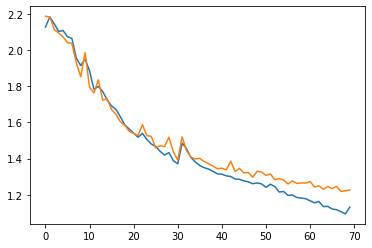

In [24]:
# visualize training/validation loss
plt.plot(trainer.loss_history[0])
plt.plot(trainer.loss_history[1])

# some forgetting, could rerun

In [25]:
# trainer.evaluate with testloader
prob, pred, true = trainer.evaluate(testloader)

In [26]:
from sklearn.metrics import classification_report

In [27]:
cr = classification_report(true, pred, target_names=ligands)

In [28]:
print(cr) # similar results to apeksha's model ~ 55% accuracy

              precision    recall  f1-score   support

         TNF       0.57      0.63      0.60      1501
         R84       0.69      0.72      0.70      1512
         PIC       0.59      0.62      0.61      1502
         P3K       0.54      0.57      0.56      1520
         FLA       0.45      0.37      0.41      1549
         CpG       0.41      0.43      0.42      1597
         FSL       0.37      0.25      0.30      1582
         LPS       0.41      0.46      0.43      1567
         UST       0.92      0.98      0.95      1578

    accuracy                           0.56     13908
   macro avg       0.55      0.56      0.55     13908
weighted avg       0.55      0.56      0.55     13908



In [29]:
fraction = Fraction(true, prob)

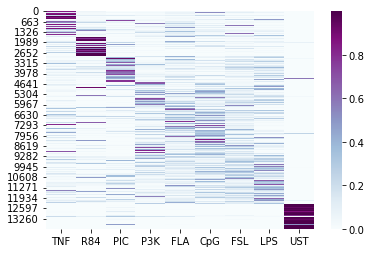

In [30]:
cf = sns.heatmap(fraction, cmap="BuPu", xticklabels=ligands)

## Polarization State Analysis

In [31]:
# refactor each polarization test_X and test_Y into torchdata object
# evaluate each one separately then concat and evaluate holistically

m0_test = TorchData(m0_test_X, m0_test_Y)
ib_test = TorchData(ib_test_X, ib_test_Y)
ig_test = TorchData(ig_test_X, ig_test_Y)
i0_test = TorchData(i0_test_X, i0_test_Y)
i3_test = TorchData(i3_test_X, i3_test_Y)
i4_test = TorchData(i4_test_X, i4_test_Y)

In [32]:
m0_loader = torch.utils.data.DataLoader(m0_test, batch_size=64, shuffle=True)
ib_loader = torch.utils.data.DataLoader(ib_test, batch_size=64, shuffle=True)
ig_loader = torch.utils.data.DataLoader(ig_test, batch_size=64, shuffle=True)
i0_loader = torch.utils.data.DataLoader(i0_test, batch_size=64, shuffle=True)
i3_loader = torch.utils.data.DataLoader(i3_test, batch_size=64, shuffle=True)
i4_loader = torch.utils.data.DataLoader(i4_test, batch_size=64, shuffle=True)

In [33]:
m0_prob, m0_pred, m0_true = trainer.evaluate(m0_loader)

In [34]:
ib_prob, ib_pred, ib_true = trainer.evaluate(ib_loader)

In [35]:
ig_prob, ig_pred, ig_true = trainer.evaluate(ig_loader)

In [36]:
i0_prob, i0_pred, i0_true = trainer.evaluate(i0_loader)

In [37]:
i3_prob, i3_pred, i3_true = trainer.evaluate(i3_loader)

In [38]:
i4_prob, i4_pred, i4_true = trainer.evaluate(i4_loader)

### M0

              precision    recall  f1-score      support
TNF            0.598726  0.686131  0.639456   274.000000
R84            0.690789  0.833333  0.755396   252.000000
PIC            0.750000  0.761538  0.755725   260.000000
P3K            0.455782  0.544715  0.496296   246.000000
FLA            0.462222  0.417671  0.438819   249.000000
CpG            0.383764  0.414343  0.398467   251.000000
FSL            0.447552  0.241509  0.313725   265.000000
LPS            0.517094  0.463602  0.488889   261.000000
UST            0.951673  0.984615  0.967864   260.000000
accuracy       0.594909  0.594909  0.594909     0.594909
macro avg      0.584178  0.594162  0.583849  2318.000000
weighted avg   0.585707  0.594909  0.584906  2318.000000


<AxesSubplot:>

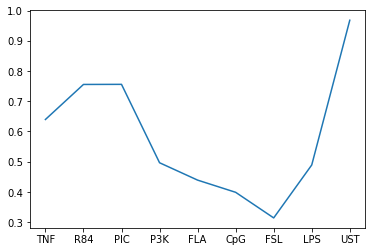

In [39]:
m0_cr = classification_report(m0_true, m0_pred, target_names=ligands, output_dict=True)
m0_crdf = pd.DataFrame(m0_cr).transpose()
print(m0_crdf)

m0_crdf[:9]['f1-score'].plot()

### ib

              precision    recall  f1-score      support
TNF            0.521930  0.481781  0.501053   247.000000
R84            0.731707  0.762712  0.746888   236.000000
PIC            0.492701  0.551020  0.520231   245.000000
P3K            0.707547  0.600000  0.649351   250.000000
FLA            0.420233  0.395604  0.407547   273.000000
CpG            0.431535  0.390977  0.410256   266.000000
FSL            0.363636  0.223881  0.277136   268.000000
LPS            0.325243  0.490842  0.391241   273.000000
UST            0.911661  0.992308  0.950276   260.000000
accuracy       0.538395  0.538395  0.538395     0.538395
macro avg      0.545133  0.543236  0.539331  2318.000000
weighted avg   0.540116  0.538395  0.534237  2318.000000


<AxesSubplot:>

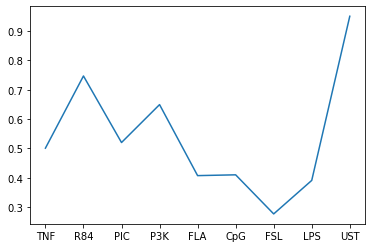

In [40]:
ib_cr = classification_report(ib_true, ib_pred, target_names=ligands, output_dict=True)
ib_crdf = pd.DataFrame(ib_cr).transpose()
print(ib_crdf)

ib_crdf[:9]['f1-score'].plot()

### ig

              precision    recall  f1-score      support
TNF            0.624506  0.591760  0.607692   267.000000
R84            0.675000  0.756000  0.713208   250.000000
PIC            0.689441  0.423664  0.524823   262.000000
P3K            0.449591  0.632184  0.525478   261.000000
FLA            0.348993  0.208835  0.261307   249.000000
CpG            0.291457  0.228346  0.256071   254.000000
FSL            0.231959  0.169173  0.195652   266.000000
LPS            0.352809  0.638211  0.454414   246.000000
UST            0.955556  0.980989  0.968105   263.000000
accuracy       0.514668  0.514668  0.514668     0.514668
macro avg      0.513257  0.514351  0.500750  2318.000000
weighted avg   0.515187  0.514668  0.502052  2318.000000


<AxesSubplot:>

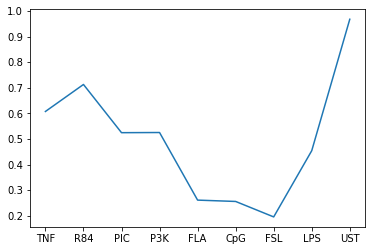

In [41]:
ig_cr = classification_report(ig_true, ig_pred, target_names=ligands, output_dict=True)
ig_crdf = pd.DataFrame(ig_cr).transpose()
print(ig_crdf)

ig_crdf[:9]['f1-score'].plot()

### i0

              precision    recall  f1-score      support
TNF            0.569620  0.762712  0.652174   236.000000
R84            0.639286  0.696498  0.666667   257.000000
PIC            0.645914  0.661355  0.653543   251.000000
P3K            0.426357  0.447154  0.436508   246.000000
FLA            0.483146  0.320896  0.385650   268.000000
CpG            0.467320  0.488055  0.477462   293.000000
FSL            0.357759  0.332000  0.344398   250.000000
LPS            0.408333  0.371212  0.388889   264.000000
UST            0.988048  0.980237  0.984127   253.000000
accuracy       0.557808  0.557808  0.557808     0.557808
macro avg      0.553976  0.562235  0.554380  2318.000000
weighted avg   0.551924  0.557808  0.551194  2318.000000


<AxesSubplot:>

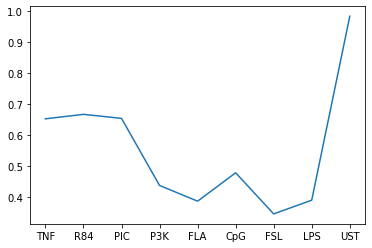

In [42]:
i0_cr = classification_report(i0_true, i0_pred, target_names=ligands, output_dict=True)
i0_crdf = pd.DataFrame(i0_cr).transpose()
print(i0_crdf)

i0_crdf[:9]['f1-score'].plot()

### i3

              precision    recall  f1-score      support
TNF            0.537634  0.655022  0.590551   229.000000
R84            0.671329  0.713755  0.691892   269.000000
PIC            0.569444  0.709957  0.631985   231.000000
P3K            0.635468  0.501946  0.560870   257.000000
FLA            0.452915  0.410569  0.430704   246.000000
CpG            0.407407  0.505300  0.451104   283.000000
FSL            0.449102  0.278810  0.344037   269.000000
LPS            0.476596  0.404332  0.437500   277.000000
UST            0.891608  0.992218  0.939227   257.000000
accuracy       0.569888  0.569888  0.569888     0.569888
macro avg      0.565723  0.574657  0.564208  2318.000000
weighted avg   0.563954  0.569888  0.560922  2318.000000


<AxesSubplot:>

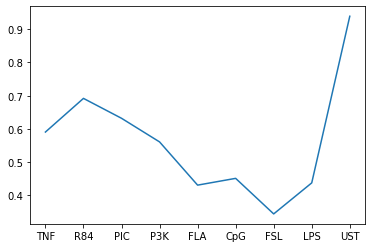

In [43]:
i3_cr = classification_report(i3_true, i3_pred, target_names=ligands, output_dict=True)
i3_crdf = pd.DataFrame(i3_cr).transpose()
print(i3_crdf)

i3_crdf[:9]['f1-score'].plot()

### i4

              precision    recall  f1-score      support
TNF            0.537906  0.600806  0.567619   248.000000
R84            0.737113  0.576613  0.647059   248.000000
PIC            0.479412  0.644269  0.549747   253.000000
P3K            0.688462  0.688462  0.688462   260.000000
FLA            0.518367  0.481061  0.499018   264.000000
CpG            0.433022  0.556000  0.486865   250.000000
FSL            0.425676  0.238636  0.305825   264.000000
LPS            0.507389  0.418699  0.458797   246.000000
UST            0.845455  0.978947  0.907317   285.000000
accuracy       0.580242  0.580242  0.580242     0.580242
macro avg      0.574756  0.575944  0.567857  2318.000000
weighted avg   0.577977  0.580242  0.571601  2318.000000


<AxesSubplot:>

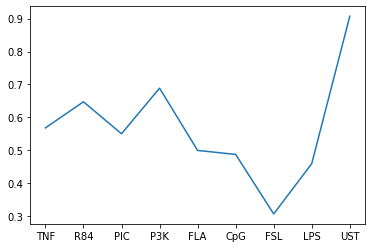

In [44]:
i4_cr = classification_report(i4_true, i4_pred, target_names=ligands, output_dict=True)
i4_crdf = pd.DataFrame(i4_cr).transpose()
print(i4_crdf)

i4_crdf[:9]['f1-score'].plot()

## Holistic

In [45]:
total_f1 = pd.concat([m0_crdf['f1-score'], ib_crdf['f1-score'], ig_crdf['f1-score'], i0_crdf['f1-score'], i3_crdf['f1-score'], i4_crdf['f1-score']], axis=1)
total_f1 = total_f1.set_axis(['M0', 'IB', 'IG', 'I0', 'I3', 'I4'], axis=1)

In [46]:
total_f1.iloc[:9]

,M0,IB,IG,I0,I3,I4
TNF,0.639456,0.501053,0.607692,0.652174,0.590551,0.567619
R84,0.755396,0.746888,0.713208,0.666667,0.691892,0.647059
PIC,0.755725,0.520231,0.524823,0.653543,0.631985,0.549747
P3K,0.496296,0.649351,0.525478,0.436508,0.560870,0.688462
FLA,0.438819,0.407547,0.261307,0.385650,0.430704,0.499018
CpG,0.398467,0.410256,0.256071,0.477462,0.451104,0.486865
FSL,0.313725,0.277136,0.195652,0.344398,0.344037,0.305825
LPS,0.488889,0.391241,0.454414,0.388889,0.437500,0.458797
UST,0.967864,0.950276,0.968105,0.984127,0.939227,0.907317


<AxesSubplot:>

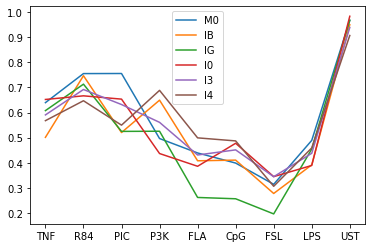

In [47]:
total_f1.iloc[:9].plot()

<AxesSubplot:>

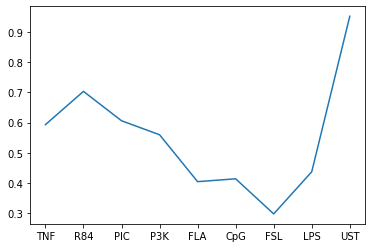

In [52]:
np.mean(total_f1.iloc[:9], axis=1).plot()

<AxesSubplot:>

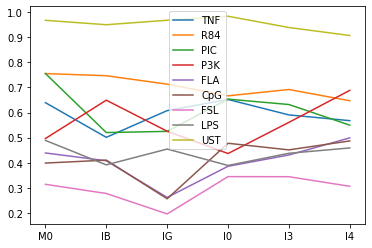

In [49]:
total_f1.iloc[:9].transpose().plot()

In [50]:
# average f1 score for all ligands across each polarization state
np.mean(total_f1.iloc[:9])

M0    0.583849
IB    0.539331
IG    0.500750
I0    0.554380
I3    0.564208
I4    0.567857
dtype: float64

<AxesSubplot:>

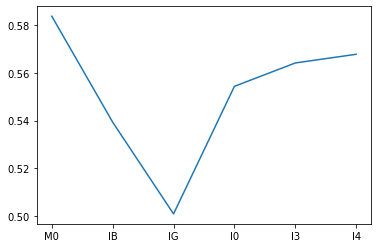

In [51]:
np.mean(total_f1.iloc[:9]).plot()